Ema's Quantum Computer

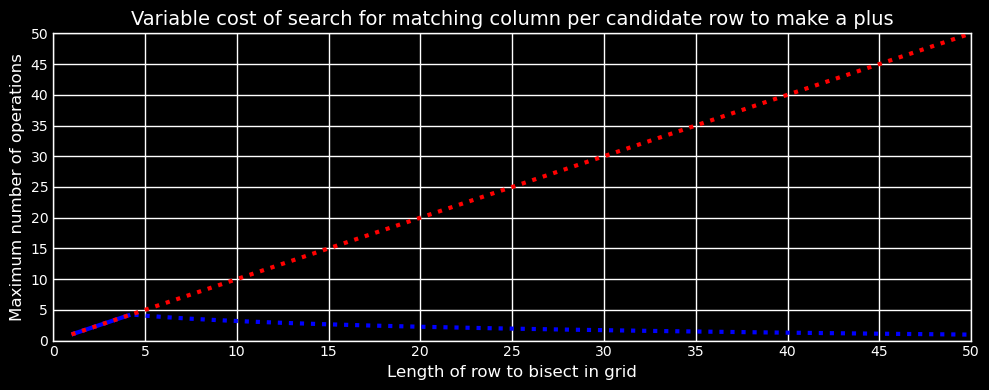

In [1]:

from colour import Color
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from math import log2, sqrt

plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.autolayout"] = True
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.style.use('dark_background')

n = 1000

def f(x, n):
    x = np.minimum(x, np.log2(100 / (x + 1)))  # Use np.minimum for element-wise minimum
    return x

def f2(x):
    return x

plt.xlabel('Length of row to bisect in grid', fontsize='12')
plt.ylabel('Maximum number of operations', fontsize='12')
plt.title(f'Variable cost of search for matching column per candidate row to make a plus', fontsize='14')

n = 100  # Example value for n
x = np.linspace(1, 3000, 100_000)
x2 = np.linspace(1, 4.2,1000)

plt.plot(x, f(x, n),':', color=Color('blue').get_hex_l(), linewidth=3)
plt.plot(x2, f2(x2), color=Color('blue').get_hex_l(), linewidth=3)

plt.plot(x, f2(x), ':', color=Color('red').get_hex_l(), linewidth=3)




rng = 50
ax = plt.gca()
ax.set_xlim([0, rng])
ax.set_xticks(list(i for i in range(0,rng+1,5)))
ax.set_ylim([0,rng])
ax.set_yticks(list(i for i in range(0,rng+1,5)))

plt.show()


In [2]:
def populate(grid)->dict:
    d = {}
    dflat = {}
    def populate2():
        if L not in d:
            d[L] = {}
        inner_dict = d[L]
        if rownum not in inner_dict:
            inner_dict[rownum] = []
        inner_dict[rownum].append((right,L))
    def populate_flat():
        for j in range(starti,right+1):
            # print(f'inserting key, ({rownum}, {j}) : ({right}, {L})')
            dflat[(rownum, j)] = (right, L)
    for rownum,row in enumerate(grid):
        start = False
        starti = -1
        for i,val in enumerate(row):
            print(rownum, i)
            if val == 'G':
                if not start:
                    start = True
                    starti = i
            else:
                if start:    # here we find our end point 
                    start = False
                    L = i - starti
                    right = i - 1
                    populate2()
                    populate_flat()
        else:
            print(rownum, i)
            if start:
                L = i - starti + 1
                right = i
                populate2()
                populate_flat()
    return d, dflat

In [3]:
def print_2d_dict(d,outerkey='key1',innerkey='key2', title = 'printing 2d dict'):
    print(title)
    for key,inner_dict in d.items():
        print(outerkey,key)
        for row,rightlist in inner_dict.items():
            print(innerkey,row,'list',rightlist)
    print('*******************')

In [101]:
from bisect import bisect_left
from collections import deque
from heapq import merge
from itertools import tee
def twoPluses(grid):
    n = len(grid)
    m = len(grid[0])

    def populate(grid)->dict:
        d = {}
        dflat = {}
        def populate2():
            if L not in d:
                d[L] = {}
            inner_dict = d[L]
            if rownum not in inner_dict:
                inner_dict[rownum] = []
            inner_dict[rownum].append((right,L))
        def populate_flat():
            for j in range(starti,right+1):
                # print(f'inserting key, ({rownum}, {j}) : ({right}, {L})')
                dflat[(rownum, j)] = (right, L)
        for rownum,row in enumerate(grid):
            start = False
            starti = -1
            for i,val in enumerate(row):
                # print(rownum, i)
                if val == 'G':
                    if not start:
                        start = True
                        starti = i
                else:
                    if start:    # here we find our end point 
                        start = False
                        L = i - starti
                        right = i - 1
                        populate2()
                        populate_flat()
            else:
                # print(rownum, i)
                if start:
                    L = i - starti + 1
                    right = i
                    populate2()
                    populate_flat()
        return d, dflat
    
    class Plus:
        def __init__(self):
            self.plusses = {}
            self.decr_plus = {}
            self._maxprod = 1
            self.lower_bound = -1
            self.upper_bound = None
            self.L_prev = None

        def add(self,row,col,L):
            volume = L * 2 - 1
            t = (row, col)
            self.plusses[t] = volume
            if volume not in self.decr_plus:
                self.decr_plus[volume] = []
            self.decr_plus[volume].append(t)

        def __contains__(self, rctuple):
            return rctuple in self.plusses
        
        @property
        def maxprod(self):
            return self._maxprod
        @maxprod.setter
        def maxprod(self, value):
            if self._maxprod < value:
                self._maxprod = value
            else:
                print(f'{value} too small to set as maxprod: {self.maxprod}')
        
        def find_max_prod(self, L):
            L_V = L*2 - 1
            keys_large = sorted(list(self.decr_plus.keys()),reverse=True)
            print(f'find_max_prod with L {L}, L_V {L_V}, keys_large {keys_large}')
            if not self.upper_bound:
                self.upper_bound = keys_large[0]
                print(f'setting upper bound {self.upper_bound}')
            if not self.L_prev:
                self.L_prev = keys_large[0] + 1    # one largest than possible volume (include all)
                print(f'setting L_prev as {self.L_prev}')

            keys_small = []    # key from previous max down to new max, computing products
            for key in keys_large:
                self.decr_plus[key].sort(key = lambda x: x[0] + x[1])
                if self.L_prev > key >= L_V:
                    print('appending',key,'to keys_small')
                    keys_small.append(key)
                elif key < L_V:
                    print('no valid keys to iterate over left current keys_small:',keys_small)
                    break
            self.L_prev = L_V
            while keys_large and keys_large[-1] < L_V:
                del keys_large[-1]
            print(f'keys large {keys_large}')
            for V in keys_small:
                print(f'for V {V} in keys_small')
                if V * self.upper_bound <= self.maxprod or V < L_V:    # halt if not possible to improve or below heuristic range
                    print(f'return early at search volume {V} upper_bound {self.upper_bound} <= {self.maxprod} or {V} < {L_V}')
                    return
                self.decr_plus[V].sort(key = lambda x: x[0] + x[1]) # L1 norm sorting asc
                centers_small = self.decr_plus[V]
                print(centers_small, 'centers small')
                for V_large in keys_large:
                    print(f'for V_large {V_large} in keys_large')
                    if V_large < V or V * V_large < self.maxprod:
                        print("returning early at v_large loop")
                        return
                    centers_Large = self.decr_plus[V_large]
                    print(f'centers large {centers_Large}')
                    for c in centers_small:
                        for C in reversed(centers_Large):
                            print(f'find prod c {c} C {C} V {V} V_large {V_large}')
                            self.find_prod(c, C, V, V_large)
                            if V * V_large < self.maxprod:
                                return
            print('no independent prods found')

        def find_prod(self, a, b, V, V2):  # due to order of input, a <= b
            arm1 = (V-1)//4
            arm2 = (V2-1)//4
            print(f'find prod a {a} b {b} v {V} v2 {V2} arm1 {arm1} arm2 {arm2}')
            if a == b: return
            x = abs(a[0]-b[0])
            y = abs(a[1]-b[1])
            
            if not x or not y:
                if arm1 + arm2 < max(x,y):
                    self.maxprod = V * V2
                    return
                else:
                    space = max(x, y) - 1
                    arm_small = min(arm1, arm2, space//2)
                    self.maxprod = (arm_small * 4 + 1) * ((space - arm_small) * 4 + 1)
                    return
            x -= 1
            y -= 1
            axbyconflict = (arm1 >= x and arm2 >= y)
            aybxconflict = (arm1 >= y and arm2 >= x)
            if not axbyconflict and not aybxconflict:    # no conflict
                self.maxprod = V * V2
            elif axbyconflict and aybxconflict:    # the error is symmetric and larger must win
                self.maxprod = (min(x, y) * 4 + 1) * V2
            elif axbyconflict:    # only axby conflict this requires permutation
                self.maxprod = max((x * 4 + 1) * V2), (V * (y * 4 + 1))    # max((a_small * b), (a * b_small))
            else:    # only aybx conflict
                self.maxprod = max((y * 4 + 1) * V), (V * (x * 4 + 1))    # max((a_small * b), (a * b_small))

        def is_no_longer_viable(self):
            if self.upper_bound * self.L_prev <= self.maxprod:
                print(f'no longer viable at upper {self.upper_bound} L_prev {self.L_prev} maxprod {self.maxprod}')
                return True
            else:
                print(f'still viable at upper {self.upper_bound} L_prev {self.L_prev} maxprod {self.maxprod}')
                return False

        def print(self):
            print('printing plusses')
            i = 0
            for key, value in self.plusses.items():
                print(key,value,end=' ')
                i +=1
                if i % 8 ==  0: print()
            print()

    dplus = Plus()

    drow, drowflat = populate(grid)
    dcol, dcolflat = populate(zip(*grid))

    #find each centroid that is a valid + and enter into dict
    def search_at_L(search_descending, L, dplus, d_in, dflat, transpose_row_col = False):
        def search_in(L, fixed_row, fixed_column):    # searching across fixed column for fixed row index
            search_tuple = dflat[(fixed_column, fixed_row)]
            search_right = search_tuple[0]
            search_length = search_tuple[1]
            L_2 = L // 2
            left_bound = search_right - search_length + 1
            # if transpose_row_col:
            #     print('row',fixed_column,'col',fixed_row,'search_tuple',search_tuple)
            # else:
            #     print('row',fixed_row,'col',fixed_column,'search_tuple',search_tuple)

            max_plus = min((fixed_row - left_bound), L_2, (search_right - fixed_row)) * 2 + 1

            if transpose_row_col:
                print('Valid Plus at centroid: ', fixed_column, fixed_row, max_plus)
                dplus.add(fixed_column, fixed_row, max_plus)
            else:
                print('Valid Plus at centroid: ', fixed_row, fixed_column, max_plus)
                dplus.add(fixed_row, fixed_column, max_plus)

        if L not in d_in:
            print('no L')
            return
        search_descending.append(L)
        if L % 2 == 0:    # necessary because even lengths are not valid +, just encoded this way for global simplicity
            print('adjusting L')
            L -= 1    # L will always be odd so L//2 will work
        L_2 = L//2

        for L_scope in search_descending:
            L_neg = L - L_scope
            if L_neg:
                paddings_tuple = (L_neg, 0)    # L_neg will always be negative or 0 so ex. (-2, 0) for a scope of 5 and L of 3
            else:
                paddings_tuple = (0,)

            inner_dict = d_in[L_scope]    # inner dict that contains key row and value right with length L i.e. 8 7 6 5
            for row, rightlist in inner_dict.items():    #for each row get the list of valid rights of length L_scope
                for right_tuple in rightlist:    # tuple (right, L)
                    for padding in paddings_tuple:    # example padding -2,0
                        right_temp = right_tuple[0] + padding
                        column = right_temp - L_2    # candidate column for centroid at (row,column) to make a plus
                        # if transpose_row_col:
                        #     print(f'L {L} rightlist {rightlist} row/column ({column}, {row})')
                        # else:
                        #     print(f'L {L} rightlist {rightlist} row/column ({row}, {column})')
                        if transpose_row_col:
                            indplus = (column, row) in dplus
                        else:
                            indplus = (row, column) in dplus
                        if indplus:
                            # if transpose_row_col:
                            #     print(f'already searched this row col ({column}, {row})')
                            # else:
                            #     print(f'already searched this row col ({row}, {column})')
                            continue
                        else:
                            search_in(L, row, column)

    # print('printing dictionaries')
    # print_2d_dict(drow,'L','row')


    # print('doing dcol')
    # print_2d_dict(dcol,'L','col')

    longest = sorted(list(drow.keys() | dcol.keys()))
    search_descending_rows = []
    search_descending_cols = []

    while longest and longest[-1] > dplus.lower_bound:    # for each L from highest
        L = longest.pop()
        print('L decremented to: ', L)
        print('search at rows')
        search_at_L(search_descending_rows, L,dplus, drow, dcolflat)    # search drow[L] for all rights of length L
        print('search_at_cols')
        search_at_L(search_descending_cols, L,dplus, dcol, drowflat, transpose_row_col=True)

        dplus.find_max_prod(L)
        if dplus.is_no_longer_viable():
            print(f'found max at {dplus.maxprod}')
            break
        else:
            print(f'current max prod is {dplus.maxprod}')
        print('**************************')

    dplus.print()


In [102]:
twoPluses(grid)

L decremented to:  5
search at rows
Valid Plus at centroid:  2 2 5
search_at_cols
find_max_prod with L 5, L_V 9, keys_large [9]
setting upper bound 9
setting L_prev as 10
appending 9 to keys_small
keys large [9]
for V 9 in keys_small
[(2, 2)] centers small
for V_large 9 in keys_large
centers large [(2, 2)]
find prod c (2, 2) C (2, 2) V 9 V_large 9
find prod a (2, 2) b (2, 2) v 9 v2 9 arm1 2 arm2 2
no independent prods found
still viable at upper 9 L_prev 9 maxprod 1
current max prod is 1
**************************
L decremented to:  4
search at rows
adjusting L
Valid Plus at centroid:  2 1 1
Valid Plus at centroid:  2 3 1
Valid Plus at centroid:  3 3 1
Valid Plus at centroid:  3 4 3
search_at_cols
no L
find_max_prod with L 4, L_V 7, keys_large [9, 5, 1]
no valid keys to iterate over left current keys_small: []
keys large [9]
no independent prods found
still viable at upper 9 L_prev 7 maxprod 1
current max prod is 1
**************************
L decremented to:  3
search at rows
no L
sea

In [93]:
grid = [
    'BBGBBBB',
    'BBGBBBB',
    'GGGGGBB',
    'BBGGGGB',
    'BBGBGBB'
]

In [24]:
grid = [
    'BGGGB',
    'GGGGG',
    'BGGGB',
]

In [ ]:
grid = [
'GGGGGG',
'GBBBGB',
'GGGGGG',
'GGBBGB',
'GGGGGG',
]

In [ ]:
import timeit

list_time = timeit.timeit('["a", "b", "c", "d"]', number=1000000)
tuple_time = timeit.timeit('("a", "b", "c", "d")', number=1000000)

print(f"List creation time: {list_time}")
print(f"Tuple creation time: {tuple_time}")


List creation time: 0.04958500000066124
Tuple creation time: 0.01015340001322329


In [ ]:
import timeit

# Timing "if L:"
time_if_L = timeit.timeit('L = 2\nif L < 3:\n pass', number=1000000)

# Timing "if L == 0:"
time_if_L_eq_0 = timeit.timeit('L = 2\nif L == 0:\n pass', number=1000000)

print(f"Timing for 'if L:': {time_if_L} seconds")
print(f"Timing for 'if L == 0:': {time_if_L_eq_0} seconds")


Timing for 'if L:': 0.01944579999690177 seconds
Timing for 'if L == 0:': 0.01678140000149142 seconds


printing merge cols
0 []
4 []
1 []
2 []
3 []
5 []
*******************
printing merge rows
0 []
2 []
4 []
1 []
3 []
*******************
printing 2d dict
row 0
L 6 list [(5, 6)]
row 2
L 6 list [(5, 6)]
row 4
L 6 list [(5, 6)]
row 1
L 1 list [(0, 1), (4, 1)]
row 3
L 1 list [(4, 1)]
L 2 list [(1, 2)]
*******************
printing 2d dict
col 0
L 5 list [(4, 5)]
col 4
L 5 list [(4, 5)]
col 1
L 1 list [(0, 1)]
L 3 list [(4, 3)]
col 2
L 1 list [(0, 1), (2, 1), (4, 1)]
col 3
L 1 list [(0, 1), (2, 1), (4, 1)]
col 5
L 1 list [(0, 1), (2, 1), (4, 1)]

printing merge rows
0 [(5, 6)]
2 [(5, 6)]
4 [(5, 6)]
1 []
3 []
*******************
printing merge cols
0 [(4, 5)]
4 [(4, 5)]
1 [(0, 1), (4, 3)]
2 []
3 []
5 [(0, 1), (2, 1), (4, 1)]
*******************
printing 2d dict
row 0
row 2
row 4
row 1
L 1 list [(0, 1), (4, 1)]
row 3
L 1 list [(4, 1)]
L 2 list [(1, 2)]
*******************
printing 2d dict
col 0
col 4
col 1
col 2
L 1 list [(0, 1), (2, 1), (4, 1)]
col 3
L 1 list [(0, 1), (2, 1), (4, 1)]
col 5
*******************
[(0, 2, 5), (4, 2, 5), (0, 0, 1), (0, 5, 1), (2, 0, 1), (2, 5, 1), (4, 0, 1), (4, 5, 1), (3, 0, 1), (3, 1, 1), (0, 0, 1), (0, 5, 1), (2, 0, 1), (2, 5, 1), (4, 0, 1), (4, 5, 1), (3, 0, 1), (3, 1, 1), (1, 0, 1), (1, 4, 1), (3, 4, 1), (0, 0, 1), (0, 4, 1), (4, 0, 1), (4, 4, 1), (1, 2, 1), (1, 4, 1), (1, 0, 1), (2, 0, 1), (2, 2, 1), (2, 4, 1), (3, 0, 1), (3, 2, 1), (3, 4, 1), (5, 0, 1), (5, 2, 1), (5, 4, 1)]